# 09. Recurrent Neural Network with PyTorch
## 1. About Recurrent Neural Network

### Step 1: Loading MNIST Train Dataset
**Images from 1 to 9**

In [176]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets
import numpy as np
import matplotlib.pyplot as plt

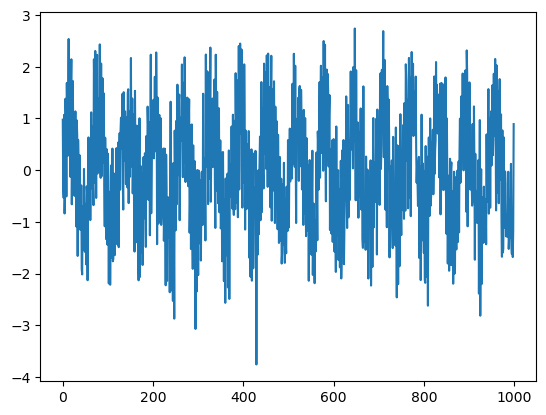

In [177]:
# make the original data
ds_length=20_000
series = np.sin(0.1*np.arange(ds_length)) + np.cos(2*np.arange(ds_length))+ np.random.randn(ds_length)*0.5

# plot it
plt.plot(series[:1000])
plt.show()

In [178]:
### build the dataset
# let's see if we can use T past values to predict the next value
T = 100
D = 1
X = []
Y = []
# rolling window
for t in range(len(series) - T):
    x = series[t:t+T]
    X.append(x)
    y = series[t+T]
    Y.append(y)

X = np.array(X).reshape(-1, T, D) # Now the data should be N x T x D
Y = np.array(Y)
N = len(X)
print("X.shape", X.shape, "Y.shape", Y.shape)

X.shape (19900, 100, 1) Y.shape (19900,)


In [179]:
X_train, Y_train = X[:-N//2], Y[:-N//2]
X_test, Y_test = X[-N//2:], Y[-N//2:]
X_train.shape, Y_train.shape

((9950, 100, 1), (9950,))

In [180]:
X_train = torch.tensor(X_train, dtype=torch.float32)
Y_train = torch.tensor(Y_train, dtype=torch.float32).reshape(-1, 1)

X_test = torch.tensor(X_test, dtype=torch.float32)
Y_test = torch.tensor(Y_test, dtype=torch.float32).reshape(-1, 1)

In [181]:
Y_test.shape

torch.Size([9950, 1])

### Step 2: Make Dataset Iterable

In [182]:
batch_size = 16
n_iters = 12000
num_epochs = n_iters // (len(series) // batch_size)
print(num_epochs)
num_epochs = int(num_epochs)

# train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
#                                           batch_size=batch_size,
#                                           shuffle=True)

# test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
#                                          batch_size=batch_size,
#                                          shuffle=False)

train_loader = torch.utils.data.DataLoader(list(zip(X_train, Y_train)), shuffle=True, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(list(zip(X_test, Y_test)), shuffle=False, batch_size=batch_size)
for X_batch, y_batch in train_loader:
    print(X_batch.shape, y_batch.shape)
    break

9
torch.Size([16, 100, 1]) torch.Size([16, 1])


In [183]:
class RNNModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super(RNNModel, self).__init__()
        # Hidden dimensions
        self.hidden_dim = hidden_dim

        # Number of hidden layers
        self.layer_dim = layer_dim

        # Building your RNN
        # batch_first=True causes input/output tensors to be of shape
        # (batch_dim, seq_dim, input_dim)
        self.rnn = nn.RNN(input_dim, hidden_dim, layer_dim, batch_first=True, nonlinearity='relu') #

        # Readout layer
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # Initialize hidden state with zeros
        # (layer_dim, batch_size, hidden_dim)
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_()

        # We need to detach the hidden state to prevent exploding/vanishing gradients
        # This is part of truncated backpropagation through time (BPTT)
        out, hn = self.rnn(x, h0.detach())

        # Index hidden state of last time step
        # out.size() --> 100, 28, 10
        # out[:, -1, :] --> 100, 10 --> just want last time step hidden states!
        out = self.fc(out[:, -1, :])
        # out.size() --> 100, 10
        return out

### Step 4: Instantiate Model Class

- 28 time steps
    - Each time step: input dimension = 28
- 1 hidden layer
- MNIST 0-9 digits $\rightarrow$ output dimension = 10

In [184]:
input_dim = 1
hidden_dim = 32
layer_dim = 2
output_dim = 1

In [185]:
model = RNNModel(input_dim, hidden_dim, layer_dim, output_dim)

In [186]:
model

RNNModel(
  (rnn): RNN(1, 32, num_layers=2, batch_first=True)
  (fc): Linear(in_features=32, out_features=1, bias=True)
)

### Step 5: Instantiate Loss Class
- Recurrent Neural Network: **Cross Entropy Loss**
    - _Convolutional Neural Network_: **Cross Entropy Loss**
    - _Feedforward Neural Network_: **Cross Entropy Loss**
    - _Logistic Regression_: **Cross Entropy Loss**
    - _Linear Regression_: **MSE**
    

In [187]:
criterion = nn.MSELoss() #nn.CrossEntropyLoss()

$\theta = \theta - \eta \cdot \nabla_\theta$

### Step 6: Instantiate Optimizer Class
Simplified equation:

$\theta = \theta - \eta \cdot \nabla_\theta$

$\theta$: parameters (our tensors with gradient accumulation abilities)

$\eta$: learning rate (how fast we want to learn)

$\nabla_\theta$: parameters' gradients



- Even simplier equation
    - `parameters = parameters - learning_rate * parameters_gradients`
    - **At every iteration, we update our model's parameters**

In [188]:
learning_rate = 0.001

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

### Step 7: Train Model
- Process
    1. **Convert inputs/labels to tensors with gradient accumulation abilities**
        - RNN Input: (1, 28)
        - CNN Input: (1, 28, 28)
        - FNN Input: (1, 28*28)
    2. Clear gradient buffets
    3. Get output given inputs
    4. Get loss
    5. Get gradients w.r.t. parameters
    6. Update parameters using gradients
        - `parameters = parameters - learning_rate * parameters_gradients`
    7. REPEAT

In [189]:
num_epochs

9

In [190]:
# Number of steps to unroll
seq_dim = 10

iter = 0
for epoch in range(num_epochs):
    for i, (train_data_points, labels) in enumerate(train_loader):
        model.train()
        # Load images as tensors with gradient accumulation abilities
        # images = images.reshape(-1, seq_dim, input_dim).requires_grad_()

        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()

        # Forward pass to get output/logits
        # outputs.size() --> 100, 10
        outputs = model(train_data_points)

        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs, labels)

        # Getting gradients w.r.t. parameters
        loss.backward()

        # Updating parameters
        optimizer.step()

        iter += 1

        if iter % 500 == 0:
            model.eval()
            # Calculate Accuracy
            correct = 0
            total = 0
            # Iterate through test dataset
            for data_points, pred in test_loader:
                # Load images to a Torch tensors with gradient accumulation abilities
                # images = images.reshape(-1, seq_dim, input_dim)

                # Forward pass only to get logits/output
                outputs = model(data_points)
                test_loss = criterion(outputs, pred)

                outputs
                # Get predictions from the maximum value
                # _, predicted = torch.max(outputs.data, 1) falsch

                # Total number of labels
                # total += labels.size(0)

                # Total correct predictions
                # correct += (predicted == labels).sum()

            # accuracy = 100 * correct / total

            # Print Loss
            print('Iteration: {}. Train Loss: {}. Test_loss: {}'.format(iter, loss.item(), test_loss.item()))

Iteration: 500. Train Loss: 0.5472568869590759. Test_loss: 0.30293649435043335
Iteration: 1000. Train Loss: 0.4827612638473511. Test_loss: 0.30816617608070374
Iteration: 1500. Train Loss: 0.35012438893318176. Test_loss: 0.26453897356987
Iteration: 2000. Train Loss: 0.2864071726799011. Test_loss: 0.28012344241142273
Iteration: 2500. Train Loss: 0.21231910586357117. Test_loss: 0.3195342421531677
Iteration: 3000. Train Loss: 0.4252265691757202. Test_loss: 0.2795756757259369
Iteration: 3500. Train Loss: 0.21884579956531525. Test_loss: 0.2217680960893631
Iteration: 4000. Train Loss: 0.24452224373817444. Test_loss: 0.2416239231824875
Iteration: 4500. Train Loss: 0.13883693516254425. Test_loss: 0.31893444061279297
Iteration: 5000. Train Loss: 0.43820807337760925. Test_loss: 0.260831743478775
Iteration: 5500. Train Loss: 0.21659627556800842. Test_loss: 0.23295088112354279


### Model B: 2 Hidden Layer (ReLU)
- Unroll 28 time steps
    - Each step input size: 28 x 1
    - Total per unroll: 28 x 28
        - Feedforward Neural Network inpt size: 28 x 28
- **2 Hidden layer**
- ReLU Activation Function


<img src="https://drive.google.com/uc?export=view&id=1_IrmcqLUnAhDRrqy8_Ix4qZ8PUsN9409" width="900">


### Steps
- Step 1: Load Dataset
- Step 2: Make Dataset Iterable
- Step 3: Create Model Class
- **Step 4: Instantiate Model Class**
- Step 5: Instantiate Loss Class
- Step 6: Instantiate Optimizer Class
- Step 7: Train Model

In [191]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets

'''
STEP 1: LOADING DATASET
'''
train_dataset = dsets.MNIST(root='data',
                            train=True,
                            transform=transforms.ToTensor(),
                            download=True)

test_dataset = dsets.MNIST(root='data',
                           train=False,
                           transform=transforms.ToTensor())

'''
STEP 2: MAKING DATASET ITERABLE
'''

batch_size = 100
n_iters = 3000
num_epochs = n_iters / (len(train_dataset) / batch_size)
num_epochs = int(num_epochs)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False)

'''
STEP 3: CREATE MODEL CLASS
'''

class RNNModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super(RNNModel, self).__init__()
        # Hidden dimensions
        self.hidden_dim = hidden_dim

        # Number of hidden layers
        self.layer_dim = layer_dim



        # Building your RNN
        # batch_first=True causes input/output tensors to be of shape
        # (batch_dim, seq_dim, feature_dim)
        self.rnn = nn.RNN(input_dim, hidden_dim, layer_dim, batch_first=True, nonlinearity='relu')

        # Readout layer
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):

        # Initialize hidden state with zeros
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_()

        # We need to detach the hidden state to prevent exploding/vanishing gradients
        # This is part of truncated backpropagation through time (BPTT)
        out, hn = self.rnn(x, h0.detach())

        # Index hidden state of last time step
        # out.size() --> 100, 28, 100
        # out[:, -1, :] --> 100, 100 --> just want last time step hidden states!
        out = self.fc(out[:, -1, :])
        # out.size() --> 100, 10
        return out

'''
STEP 4: INSTANTIATE MODEL CLASS
'''
input_dim = 28
hidden_dim = 100
layer_dim = 2  # ONLY CHANGE IS HERE FROM ONE LAYER TO TWO LAYER
output_dim = 10

model = RNNModel(input_dim, hidden_dim, layer_dim, output_dim)

# JUST PRINTING MODEL & PARAMETERS
print(model)
print(len(list(model.parameters())))
for i in range(len(list(model.parameters()))):
    print(list(model.parameters())[i].size())

'''
STEP 5: INSTANTIATE LOSS CLASS
'''
criterion = nn.CrossEntropyLoss()

'''
STEP 6: INSTANTIATE OPTIMIZER CLASS
'''
learning_rate = 0.001

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

'''
STEP 7: TRAIN THE MODEL
'''

# Number of steps to unroll
seq_dim = 28

iter = 0
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        model.train()
        # Load images as tensors with gradient accumulation abilities
        images = images.view(-1, seq_dim, input_dim).requires_grad_()

        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()

        # Forward pass to get output/logits
        # outputs.size() --> 100, 10
        outputs = model(images)

        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs, labels)

        # Getting gradients w.r.t. parameters
        loss.backward()

        # Updating parameters
        optimizer.step()

        iter += 1

        if iter % 500 == 0:
            model.eval()
            # Calculate Accuracy
            correct = 0
            total = 0
            # Iterate through test dataset
            for images, labels in test_loader:
                # Resize images
                images = images.view(-1, seq_dim, input_dim)

                # Forward pass only to get logits/output
                outputs = model(images)

                # Get predictions from the maximum value
                _, predicted = torch.max(outputs.data, 1)

                # Total number of labels
                total += labels.size(0)

                # Total correct predictions
                correct += (predicted == labels).sum()

            accuracy = 100 * correct / total

            # Print Loss
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))

RNNModel(
  (rnn): RNN(28, 100, num_layers=2, batch_first=True)
  (fc): Linear(in_features=100, out_features=10, bias=True)
)
10
torch.Size([100, 28])
torch.Size([100, 100])
torch.Size([100])
torch.Size([100])
torch.Size([100, 100])
torch.Size([100, 100])
torch.Size([100])
torch.Size([100])
torch.Size([10, 100])
torch.Size([10])
Iteration: 500. Loss: 0.28856468200683594. Accuracy: 87.83000183105469
Iteration: 1000. Loss: 0.27339059114456177. Accuracy: 93.12999725341797
Iteration: 1500. Loss: 0.21433515846729279. Accuracy: 94.87999725341797
Iteration: 2000. Loss: 0.07946006953716278. Accuracy: 96.0199966430664


- **10 sets of parameters**
- First hidden Layer $A_1 = [100, 28]$
    - $A_3 = [100, 100]$
    - $B_1 = [100]$
    - $B_3 = [100]$
- Second hidden layer
    - $A_2 = [100, 100]$
    - $A_5 = [100, 100]$
    - $B_2 = [100]$
    - $B_5 = [100]$
- Readout layer
    - $A_5 = [10, 100]$
    - $B_5 = [10]$


<img src="https://drive.google.com/uc?export=view&id=102CUJIPzNv0QW4o0gXWoDeMA5axwJ9JW" width="900">


### Model C: 2 Hidden Layer
- Unroll 28 time steps
    - Each step input size: 28 x 1
    - Total per unroll: 28 x 28
        - Feedforward Neural Network inpt size: 28 x 28
- 2 Hidden layer
- **Tanh** Activation Function


<img src="https://drive.google.com/uc?export=view&id=1QkmuuZ7_-sljD8nzNCHCTufZFybOIHT_" width="900">

### Steps
- Step 1: Load Dataset
- Step 2: Make Dataset Iterable
- Step 3: Create Model Class
- **Step 4: Instantiate Model Class**
- Step 5: Instantiate Loss Class
- Step 6: Instantiate Optimizer Class
- Step 7: Train Model

In [ ]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets

'''
STEP 1: LOADING DATASET
'''
train_dataset = dsets.MNIST(root='data',
                            train=True,
                            transform=transforms.ToTensor(),
                            download=True)

test_dataset = dsets.MNIST(root='data',
                           train=False,
                           transform=transforms.ToTensor())

'''
STEP 2: MAKING DATASET ITERABLE
'''

batch_size = 100
n_iters = 3000
num_epochs = n_iters / (len(train_dataset) / batch_size)
num_epochs = int(num_epochs)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False)

'''
STEP 3: CREATE MODEL CLASS
'''

class RNNModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super(RNNModel, self).__init__()
        # Hidden dimensions
        self.hidden_dim = hidden_dim

        # Number of hidden layers
        self.layer_dim = layer_dim

        # Building your RNN
        # batch_first=True causes input/output tensors to be of shape
        # (batch_dim, seq_dim, feature_dim)
        self.rnn = nn.RNN(input_dim, hidden_dim, layer_dim, batch_first=True, nonlinearity='tanh')

        # Readout layer
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # Initialize hidden state with zeros
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_()

        # One time step
        # We need to detach the hidden state to prevent exploding/vanishing gradients
        # This is part of truncated backpropagation through time (BPTT)
        out, hn = self.rnn(x, h0.detach())

        # Index hidden state of last time step
        # out.size() --> 100, 28, 100
        # out[:, -1, :] --> 100, 100 --> just want last time step hidden states!
        out = self.fc(out[:, -1, :])
        # out.size() --> 100, 10
        return out

'''
STEP 4: INSTANTIATE MODEL CLASS
'''
input_dim = 28
hidden_dim = 100
layer_dim = 2  # ONLY CHANGE IS HERE FROM ONE LAYER TO TWO LAYER
output_dim = 10

model = RNNModel(input_dim, hidden_dim, layer_dim, output_dim)

# JUST PRINTING MODEL & PARAMETERS
print(model)
print(len(list(model.parameters())))
for i in range(len(list(model.parameters()))):
    print(list(model.parameters())[i].size())

'''
STEP 5: INSTANTIATE LOSS CLASS
'''
criterion = nn.CrossEntropyLoss()

'''
STEP 6: INSTANTIATE OPTIMIZER CLASS
'''
learning_rate = 0.1

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

'''
STEP 7: TRAIN THE MODEL
'''

# Number of steps to unroll
seq_dim = 28

iter = 0
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        # Load images as tensors with gradient accumulation abilities
        images = images.view(-1, seq_dim, input_dim).requires_grad_()

        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()

        # Forward pass to get output/logits
        # outputs.size() --> 100, 10
        outputs = model(images)

        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs, labels)

        # Getting gradients w.r.t. parameters
        loss.backward()

        # Updating parameters
        optimizer.step()

        iter += 1

        if iter % 500 == 0:
            # Calculate Accuracy
            correct = 0
            total = 0
            # Iterate through test dataset
            for images, labels in test_loader:
                # Resize images
                images = images.view(-1, seq_dim, input_dim)

                # Forward pass only to get logits/output
                outputs = model(images)

                # Get predictions from the maximum value
                _, predicted = torch.max(outputs.data, 1)

                # Total number of labels
                total += labels.size(0)

                # Total correct predictions
                correct += (predicted == labels).sum()

            accuracy = 100 * correct / total

            # Print Loss
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))

RNNModel(
  (rnn): RNN(28, 100, num_layers=2, batch_first=True)
  (fc): Linear(in_features=100, out_features=10, bias=True)
)
10
torch.Size([100, 28])
torch.Size([100, 100])
torch.Size([100])
torch.Size([100])
torch.Size([100, 100])
torch.Size([100, 100])
torch.Size([100])
torch.Size([100])
torch.Size([10, 100])
torch.Size([10])
Iteration: 500. Loss: 0.46521714329719543. Accuracy: 80.0999984741211
Iteration: 1000. Loss: 0.28643786907196045. Accuracy: 90.12999725341797
Iteration: 1500. Loss: 0.23399974405765533. Accuracy: 92.5199966430664
Iteration: 2000. Loss: 0.23947027325630188. Accuracy: 93.25
Iteration: 2500. Loss: 0.19799625873565674. Accuracy: 94.8499984741211
Iteration: 3000. Loss: 0.18210069835186005. Accuracy: 95.43000030517578


## Summary of Results

| Model A | Model B   | Model C |
|------|------|
|   ReLU | ReLU | Tanh |
| 1 Hidden Layer | 2 Hidden Layers | 2 Hidden Layers |
| 100 Hidden Units | 100 Hidden Units |100 Hidden Units |
| 92.48% | 95.09% | 95.54% |




### Deep Learning
- 2 ways to expand a recurrent neural network
    - More non-linear activation units (neurons)
    - More hidden layers
- Cons
    - Need a larger dataset
        - Curse of dimensionality
    - Does not necessarily mean higher accuracy

## 3. Building a Recurrent Neural Network with PyTorch (GPU)

### Model C: 2 Hidden Layer (Tanh)

<img src="https://drive.google.com/uc?export=view&id=1QkmuuZ7_-sljD8nzNCHCTufZFybOIHT_" width="900">


GPU: 2 things must be on GPU
- `model`
- `tensors with gradient accumulation abilities`

### Steps
- Step 1: Load Dataset
- Step 2: Make Dataset Iterable
- **Step 3: Create Model Class**
- **Step 4: Instantiate Model Class**
- Step 5: Instantiate Loss Class
- Step 6: Instantiate Optimizer Class
- **Step 7: Train Model**

In [ ]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets

'''
STEP 1: LOADING DATASET
'''
train_dataset = dsets.MNIST(root='data',
                            train=True,
                            transform=transforms.ToTensor(),
                            download=True)

test_dataset = dsets.MNIST(root='data',
                           train=False,
                           transform=transforms.ToTensor())

'''
STEP 2: MAKING DATASET ITERABLE
'''

batch_size = 100
n_iters = 3000
num_epochs = n_iters / (len(train_dataset) / batch_size)
num_epochs = int(num_epochs)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False)

'''
STEP 3: CREATE MODEL CLASS
'''

class RNNModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super(RNNModel, self).__init__()
        # Hidden dimensions
        self.hidden_dim = hidden_dim

        # Number of hidden layers
        self.layer_dim = layer_dim

        # Building your RNN
        # batch_first=True causes input/output tensors to be of shape
        # (batch_dim, seq_dim, feature_dim)
        self.rnn = nn.RNN(input_dim, hidden_dim, layer_dim, batch_first=True, nonlinearity='tanh')

        # Readout layer
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # Initialize hidden state with zeros
        #######################
        #  USE GPU FOR MODEL  #
        #######################
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).to(device)

        # One time step
        # We need to detach the hidden state to prevent exploding/vanishing gradients
        # This is part of truncated backpropagation through time (BPTT)
        out, hn = self.rnn(x, h0.detach())

        # Index hidden state of last time step
        # out.size() --> 100, 28, 100
        # out[:, -1, :] --> 100, 100 --> just want last time step hidden states!
        out = self.fc(out[:, -1, :])
        # out.size() --> 100, 10
        return out

'''
STEP 4: INSTANTIATE MODEL CLASS
'''
input_dim = 28
hidden_dim = 100
layer_dim = 2  # ONLY CHANGE IS HERE FROM ONE LAYER TO TWO LAYER
output_dim = 10

model = RNNModel(input_dim, hidden_dim, layer_dim, output_dim)

#######################
#  USE GPU FOR MODEL  #
#######################

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)


'''
STEP 5: INSTANTIATE LOSS CLASS
'''
criterion = nn.CrossEntropyLoss()

'''
STEP 6: INSTANTIATE OPTIMIZER CLASS
'''
learning_rate = 0.1

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

'''
STEP 7: TRAIN THE MODEL
'''

# Number of steps to unroll
seq_dim = 28

iter = 0
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        # Load images as tensors with gradient accumulation abilities
        #######################
        #  USE GPU FOR MODEL  #
        #######################
        images = images.view(-1, seq_dim, input_dim).requires_grad_().to(device)
        labels = labels.to(device)

        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()

        # Forward pass to get output/logits
        # outputs.size() --> 100, 10
        outputs = model(images)

        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs, labels)

        # Getting gradients w.r.t. parameters
        loss.backward()

        # Updating parameters
        optimizer.step()

        iter += 1

        if iter % 500 == 0:
            # Calculate Accuracy
            correct = 0
            total = 0
            # Iterate through test dataset
            for images, labels in test_loader:
                #######################
                #  USE GPU FOR MODEL  #
                #######################
                images = images.view(-1, seq_dim, input_dim).to(device)

                # Forward pass only to get logits/output
                outputs = model(images)

                # Get predictions from the maximum value
                _, predicted = torch.max(outputs.data, 1)

                # Total number of labels
                total += labels.size(0)

                # Total correct predictions
                #######################
                #  USE GPU FOR MODEL  #
                #######################
                if torch.cuda.is_available():
                    correct += (predicted.cpu() == labels.cpu()).sum()
                else:
                    correct += (predicted == labels).sum()

            accuracy = 100 * correct / total

            # Print Loss
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))

Iteration: 500. Loss: 0.599184513092041. Accuracy: 78.58999633789062
Iteration: 1000. Loss: 0.22469009459018707. Accuracy: 92.7699966430664
Iteration: 1500. Loss: 0.12211698293685913. Accuracy: 93.0999984741211


KeyboardInterrupt: 

# Summary

- **Feedforward Neural Networks** Transition to Recurrent Neural Networks
- **RNN Models** in PyTorch
    - Model A: 1 Hidden Layer RNN (ReLU)
    - Model B: 2 Hidden Layer RNN (ReLU)
    - Model C: 2 Hidden Layer RNN (Tanh)
- Models Variation in **Code**
    - Modifying only step 4
- Ways to Expand Model’s **Capacity**
    - More non-linear activation units (**neurons**)
    - More hidden **layers**
- **Cons** of Expanding Capacity
    - Need more **data**
    - Does not necessarily mean higher **accuracy**
- **GPU** Code
    - 2 things on GPU
        - **model**
        - **tensors with gradient accumulation abilities**
    - Modifying only **Step 3, 4 and 7**
- **7 Step** Model Building Recap
    - Step 1: Load Dataset
    - Step 2: Make Dataset Iterable
    - **Step 3: Create Model Class**
    - **Step 4: Instantiate Model Class**
    - Step 5: Instantiate Loss Class
    - Step 6: Instantiate Optimizer Class
    - **Step 7: Train Model**

